In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple
from sklearn.model_selection import train_test_split


In [2]:
# Load the JSON data
with open('../100_article_analysis/Combined_QnA_eng_India_election_2024.json', 'r') as file_eng:
    articles_eng = json.load(file_eng)

with open('../100_article_analysis/Combined_QnA_hin_India_election_2024.json', 'r') as file_hin:
    articles_hin = json.load(file_hin)


In [3]:
# Save the embeddings as a TSV file
def save_tsv(embeddings, filename):
    np.savetxt(filename, embeddings, delimiter='\t')

# Create a metadata TSV file
def save_metadata(metadata, filename):
    with open(filename, 'w') as f:
        for item in metadata:
            f.write(f"{item}\n")

In [4]:
def prepare_data(articles):
    # Extract questions and answers
    M = len(articles)
    questions = articles[0]['QnA']
    N = len(questions)

    # Create answer matrix
    answer_matrix = np.zeros((M, N), dtype=int)
    Kn = [0] * N  # Initialize number of categories per question

    for i, article in enumerate(articles):
        for j, qna in enumerate(article['QnA']):
            answer_matrix[i, j] = ord(qna['post_LLM_answer']) - ord('A')+1 # Convert answers to integers
            Kn[j] = max(Kn[j], answer_matrix[i, j])  # Update the number of categories for each question

    return M, N, answer_matrix, Kn

In [5]:
class FactorModel(nn.Module):
    def __init__(self, N: int, Kn: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.Kn = Kn  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, Kn[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(Kn[i] - 1)) for i in range(N)])

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1) for logit in logits]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities

In [27]:
def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:
    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n] - 1)  # Adjusting answers to be zero-based index
    nll_loss = total_loss.clone()

    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss


In [28]:
def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:
    # Initialize v as a learnable parameter
    v = torch.randn(len(answers), model.d, requires_grad=True)
    # Add v to the list of parameters for the optimizer
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, NLL Loss: {nllloss.item()}")

    return model, v.detach()

In [29]:
M1, N1, answer_matrix1, Kn1 = prepare_data(articles_eng)
Kn1 = [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4]
model1 = FactorModel(N1, Kn1, 3)
model1, embeddings1 = train_model(model1, torch.tensor(answer_matrix1), epochs=1000, lr=0.01, lambda1=0.01, lambda2=0.01)

Epoch 0, Loss: 4047.595703125, NLL Loss: 4044.3837890625
Epoch 100, Loss: 1541.1207275390625, NLL Loss: 1534.9691162109375
Epoch 200, Loss: 1227.3470458984375, NLL Loss: 1218.91259765625
Epoch 300, Loss: 994.342529296875, NLL Loss: 983.3546752929688
Epoch 400, Loss: 877.2646484375, NLL Loss: 864.0486450195312
Epoch 500, Loss: 811.2117919921875, NLL Loss: 795.7974853515625
Epoch 600, Loss: 772.66943359375, NLL Loss: 755.034912109375
Epoch 700, Loss: 745.9824829101562, NLL Loss: 726.1624145507812
Epoch 800, Loss: 725.1903076171875, NLL Loss: 703.2433471679688
Epoch 900, Loss: 709.2236938476562, NLL Loss: 685.2066040039062


In [30]:
print(embeddings1.shape)

torch.Size([100, 3])


In [31]:
M2, N2, answer_matrix2, Kn2 = prepare_data(articles_hin)
Kn2= [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4]
model2 = FactorModel(N2, Kn2, 3)
model2, embeddings2 = train_model(model2, torch.tensor(answer_matrix2), epochs=1000, lr=0.01, lambda1=0.01, lambda2=0.01)

Epoch 0, Loss: 3709.522216796875, NLL Loss: 3706.429443359375
Epoch 100, Loss: 1453.2684326171875, NLL Loss: 1447.364013671875
Epoch 200, Loss: 1168.160888671875, NLL Loss: 1160.2142333984375
Epoch 300, Loss: 1014.802978515625, NLL Loss: 1004.66259765625
Epoch 400, Loss: 918.614501953125, NLL Loss: 906.5177612304688
Epoch 500, Loss: 856.0891723632812, NLL Loss: 842.14794921875
Epoch 600, Loss: 813.6060791015625, NLL Loss: 797.8107299804688
Epoch 700, Loss: 783.5565795898438, NLL Loss: 765.9526977539062
Epoch 800, Loss: 763.6204833984375, NLL Loss: 744.249755859375
Epoch 900, Loss: 749.4725341796875, NLL Loss: 728.3858642578125


In [32]:
print(embeddings2.shape)

torch.Size([100, 3])


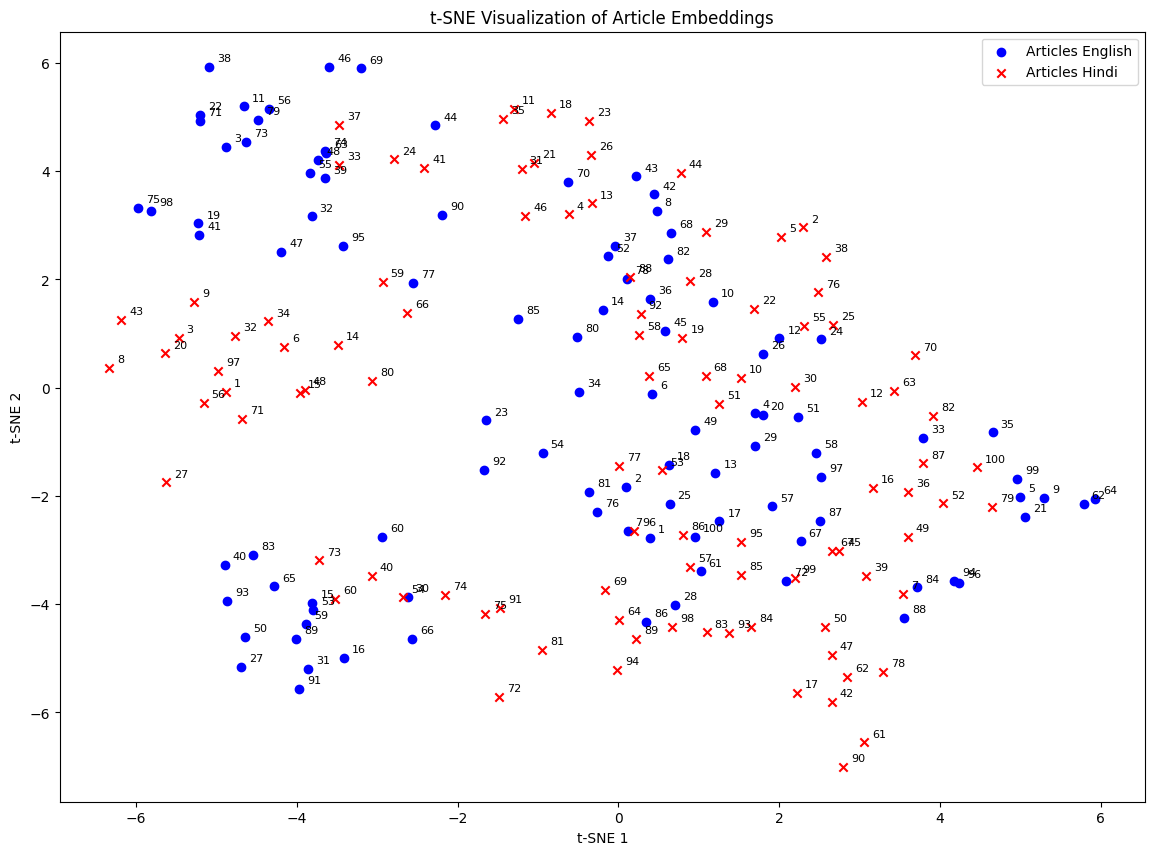

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_1 = tsne.fit_transform(embeddings1.numpy())
embeddings_2d_2 = tsne.fit_transform(embeddings2.numpy())

# Increase the plot size
plt.figure(figsize=(14, 10))

# Plot the embeddings
plt.scatter(embeddings_2d_1[:, 0], embeddings_2d_1[:, 1], c='blue', marker='o', label='Articles English')
plt.scatter(embeddings_2d_2[:, 0], embeddings_2d_2[:, 1], c='red', marker='x', label='Articles Hindi')

# Add labels for clarity, slightly offset to prevent overlap with points
for i in range(len(embeddings_2d_1)):
    plt.annotate(str(i+1), (embeddings_2d_1[i, 0] + 0.1, embeddings_2d_1[i, 1] + 0.1), fontsize=8)
for i in range(len(embeddings_2d_2)):
    plt.annotate(str(i+1), (embeddings_2d_2[i, 0] + 0.1, embeddings_2d_2[i, 1] + 0.1), fontsize=8)

plt.title('t-SNE Visualization of Article Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()
plt.show()




In [13]:
# Indices of isolated points
isolated_eng_indices = [30,89,16,91,27,15,31,66,50,93,40,60]
isolated_hin_indices = [35,97,17,51,57,26,21,5,9,33,24,18,92]

# Retrieve corresponding articles
isolated_eng_articles = [articles_eng[i] for i in isolated_eng_indices]  # Subtract 1 for zero-based index
isolated_hin_articles = [articles_hin[i] for i in isolated_hin_indices]  # Subtract 1 for zero-based index

# Print summaries
print("English Articles Summary:")
for body in isolated_eng_articles:
    print(body['body'])

print("\nHindi Articles Summary:")
for body in isolated_hin_articles:
    print(body['body'])

English Articles Summary:
Get latest articles and stories on India at LatestLY. The world experienced the warmest May ever, with record heat, rain and floods wreaking havoc in many countries, according to new data released on Wednesday.

New Delhi, Jun 5 (PTI) The world experienced the warmest May ever, with record heat, rain and floods wreaking havoc in many countries, according to new data released on Wednesday.

It was also the 12 consecutive month of record-high temperatures, a result of the combined effect of now weakening El Nino and human-caused climate change, the European Union's climate agency Copernicus Climate Change Service (C3S) said.

Also Read | AP EAMCET Results 2024: Examination Results of EAPCET To Be Announced Soon at cets.apsche.ap.gov.in, Know Steps To Check Rank Cards.

The update from Copernicus coincided with the World Meteorological Organization (WMO) prediction that there is an 80 per cent chance that one of the next five years will be at least 1.5 degrees Ce

In [14]:
#find l2 distance between embeddings
from scipy.spatial.distance import cdist

# Calculate the pairwise L2 distance between the embeddings
distances = cdist(embeddings1, embeddings2, metric='euclidean')

# Find the indices of the minimum distances
min_indices = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
min_distance = distances[min_indices]

# Find the corresponding URIs
uri1 = articles_eng[min_indices[0]]['uri']
uri2 = articles_hin[min_indices[1]]['uri']

print(f'Minimum distance: {min_distance:.4f}')
print(f'Article 1 URI: {uri1}')
print(f'Article 2 URI: {uri2}')

Minimum distance: 3.8117
Article 1 URI: 2024-06-379877250
Article 2 URI: 8160768496


In [15]:
import numpy as np

# Check for any missing or abnormal values in the answer matrices
print("Answer Matrix 1 - Min:", np.min(answer_matrix1), "Max:", np.max(answer_matrix1), "Mean:", np.mean(answer_matrix1))
print("Answer Matrix 2 - Min:", np.min(answer_matrix2), "Max:", np.max(answer_matrix2), "Mean:", np.mean(answer_matrix2))

# Check the distribution of answers
unique, counts = np.unique(answer_matrix1, return_counts=True)
print("Answer Matrix 1 Distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(answer_matrix2, return_counts=True)
print("Answer Matrix 2 Distribution:", dict(zip(unique, counts)))

Answer Matrix 1 - Min: 1 Max: 5 Mean: 2.9095454545454547
Answer Matrix 2 - Min: 1 Max: 5 Mean: 2.9095454545454547
Answer Matrix 1 Distribution: {1: 668, 2: 77, 3: 383, 4: 930, 5: 142}
Answer Matrix 2 Distribution: {1: 668, 2: 77, 3: 383, 4: 930, 5: 142}


In [16]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
# Function to find and print URIs of articles with the same or very close embeddings
def find_and_print_close_embeddings(embeddings, articles, threshold=0.1):
    # Calculate pairwise distances
    pairwise_distances = squareform(pdist(embeddings, 'euclidean'))
    
    # Identify pairs with distances below the threshold
    close_pairs = np.where(pairwise_distances < threshold)
    unique_pairs = set()
    
    for i in range(len(close_pairs[0])):
        if close_pairs[0][i] != close_pairs[1][i]:  # Exclude self-pairs
            pair = tuple(sorted((close_pairs[0][i], close_pairs[1][i])))
            unique_pairs.add(pair)
    
    # Print URIs of close pairs
    if unique_pairs:
        print("Articles with same or very close embeddings:")
        for i, j in unique_pairs:
            print(f"Article {i} (URI: {articles[i]['uri']}) and Article {j} (URI: {articles[j]['uri']})")
    else:
        print("No articles with same or very close embeddings found.")

# Find and print close embeddings for both datasets
print("For English Dataset:")
find_and_print_close_embeddings(embeddings1, articles_eng)

print("\nFor Hindi Dataset:")
find_and_print_close_embeddings(embeddings2, articles_hin)

For English Dataset:
No articles with same or very close embeddings found.

For Hindi Dataset:
No articles with same or very close embeddings found.


In [41]:
# Load the JSON data
with open('../100_article_analysis/Summary_Combined_QnA_eng_India_election_2024.json', 'r') as file_eng:
    articles_eng_summary = json.load(file_eng)

with open('../100_article_analysis/Summary_Combined_QnA_hin_India_election_2024.json', 'r') as file_hin:
    articles_hin_summary = json.load(file_hin)

embeddings_2d_1 = tsne.fit_transform(embeddings1.numpy())
embeddings_2d_2 = tsne.fit_transform(embeddings2.numpy())

# Combine embeddings and create corresponding metadata
combined_embeddings = np.concatenate((embeddings_2d_1, embeddings_2d_2), axis=0)
#append the summary from article file to metadata
metadata = [f"English: {article['Summary']}" for article in articles_eng_summary] + [f"Hindi: {article['Summary']}" for article in articles_hin_summary]
print(len(metadata))
print(metadata[0])

# Save the combined embeddings and metadata
save_tsv(combined_embeddings, 'embeddings.tsv')
save_metadata(metadata, 'metadata.tsv')

200
English: AIUDF chief Maulana Badruddin Ajmal vows to analyze the party's defeat in Assam's Dhubri constituency after a significant loss in the 2024 elections.


In [34]:
from sklearn.manifold import TSNE
combined_embeddings = torch.cat((embeddings1, embeddings2), dim=0)
latent_vectors = combined_embeddings.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
v_2d = tsne.fit_transform(latent_vectors)

In [38]:
#save embeddings in a csv file
import pandas as pd

v_2d_df = pd.DataFrame(v_2d, columns=["x", "y"])
v_2d_df.to_csv("v_2d.csv", index=False)

In [39]:
v_2d_df

,x,y
0,-0.271655,-4.930167
1,-1.730252,-4.359912
2,-13.203390,2.577692
3,-0.570324,-0.504185
4,4.435844,2.815044
...,...,...
195,3.207021,1.724615
196,12.792365,1.865729
197,1.386021,4.659348
198,-0.473261,2.051003


In [42]:
#combine two json files
articles_combined = articles_eng_summary + articles_eng_summary

In [43]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import json

v_2d_df = pd.read_csv(
    "v_2d.csv",
)
v_2d_df["language"] = ["English"] * 100 + ["Hindi"] * 100

# Read the summary from JSON file
summary = [item["Summary"] for item in articles_combined]
v_2d_df["Summary"] = summary


# Function to format summaries for hover text
def format_summary(text):
    return text.replace("\n", "<br>")


v_2d_df["formatted_summary"] = v_2d_df["Summary"].apply(format_summary)

# Plot using Plotly
fig = px.scatter(
    v_2d_df,
    x="x",
    y="y",
    color="language",
    title="t-SNE Visualization of News Articles - India elections 2024",
    labels={"x": "t-SNE component 1", "y": "t-SNE component 2"},
    hover_data={"Summary": False, "language": False, "x": False, "y": False},
    symbol="language",
    color_discrete_map={"English": "blue", "Hindi": "red"},
    symbol_map={"English": "circle", "Hindi": "cross"}
)

# Customize the hover template to instruct user to hover
fig.update_traces(
    hovertemplate="<b>Hover over a point to see the summary</b><extra></extra>",
    customdata=v_2d_df[["formatted_summary"]].values,
)
# Update layout to adjust the width of the scatter plot
fig.update_layout(width=1000)  # Set the width in pixels

# Save the plot as an HTML file with embedded JavaScript and CSS
html_content = f"""
<html>
<head>
    <title>Interactive Plot</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        #summary-box {{
            position: absolute;
            top: 10px;
            right: 10px;
            width: 400px;
            max-height: 600px;
            overflow-y: auto;
            background-color: white;
            border: 1px solid black;
            padding: 10px;
            z-index: 1000;
            white-space: pre-line;
        }}
    </style>
</head>
<body>
    <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
    <div id="summary-box">Hover over a point to see the summary here.</div>
    <script>
        document.addEventListener('DOMContentLoaded', function() {{
            const plotElement = document.querySelector('.plotly-graph-div');
            plotElement.on('plotly_hover', function(data) {{
                if(data.points.length > 0) {{
                    const summary = data.points[0].customdata[0];
                    document.getElementById('summary-box').innerHTML = summary;
                }}
            }});
            plotElement.on('plotly_unhover', function(data) {{
                document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
            }});
        }});
    </script>
</body>
</html>
"""

# Save the HTML content to a file
with open("interactive_plot.html", "w") as f:
    f.write(html_content)

English: 'summary'